In [1]:
import torch
import time
import torch.nn as nn
from datasets import get_noised_mnist_dataloader
from utils import add_gaussian_noise, add_sp_noise, add_block_mask, basic_visualize, compute_psnr
from model import MFDiT
from meanflow import MeanFlow
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/zhb/ml/image_restoration/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# visualize the test data
test_dataloader = get_noised_mnist_dataloader(noise_func_arg=0.5, train=False)
for test_data in test_dataloader:
    test_noised_img, test_clean_img, test_label = test_data
    break

label_to_index = {}
for i, label in enumerate(test_label):
    l = label.item()
    if l not in label_to_index:
        label_to_index[l] = i
    if len(label_to_index) == 10:
        break

indices = [label_to_index[i] for i in range(10)]

test_noised_img = test_noised_img[indices].to(device)
test_clean_img = test_clean_img[indices].to(device)
test_label = test_label[indices].to(device)

In [3]:
model = MFDiT(
        input_size=32,
        patch_size=2,
        in_channels=1,
        dim=144,
        depth=6,
        num_heads=3,
        num_classes=10,
    ).to(device)

state_dict = torch.load("/home/zhb/ml/image_restoration/MeanFlow/results/mf_img_restore/checkpoints/step_300000.pth")
model.load_state_dict(state_dict)
model.eval()

meanflow = MeanFlow(
    channels=3,
    image_size=32,
    num_classes=10,
    flow_ratio=0.50,
    time_dist=['lognorm', -0.4, 1.0],
    cfg_ratio=0.10,
    cfg_scale=2.0,
    # experimental
    cfg_uncond='u')

/tmp/ipykernel_6803/3186970404.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/zhb/ml/image_restoration/MeanFlow/results/mf_img_restore/c

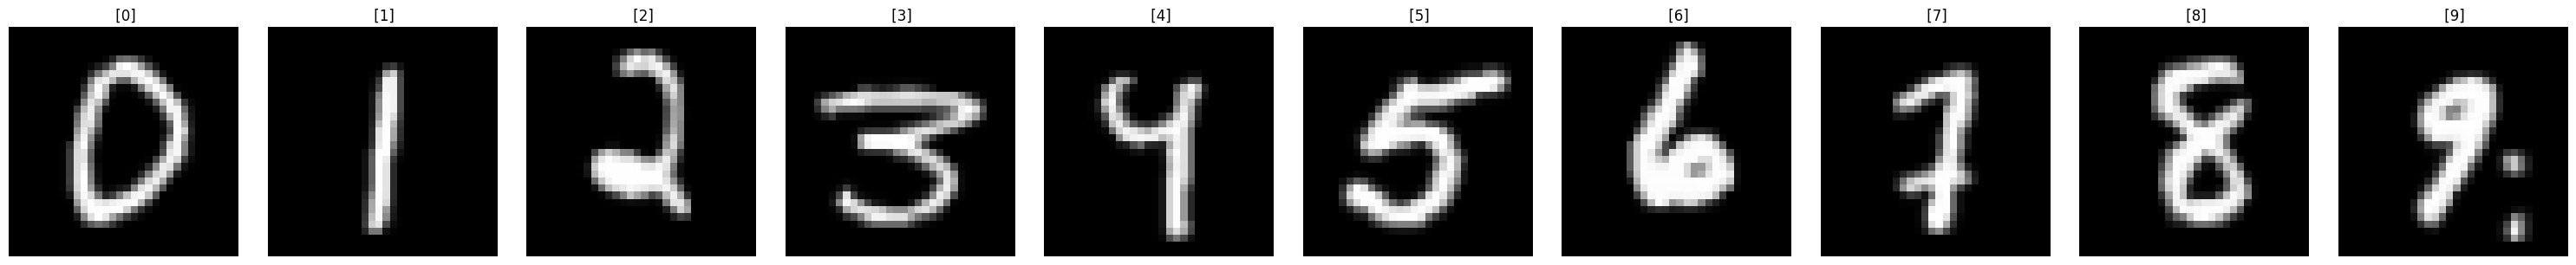

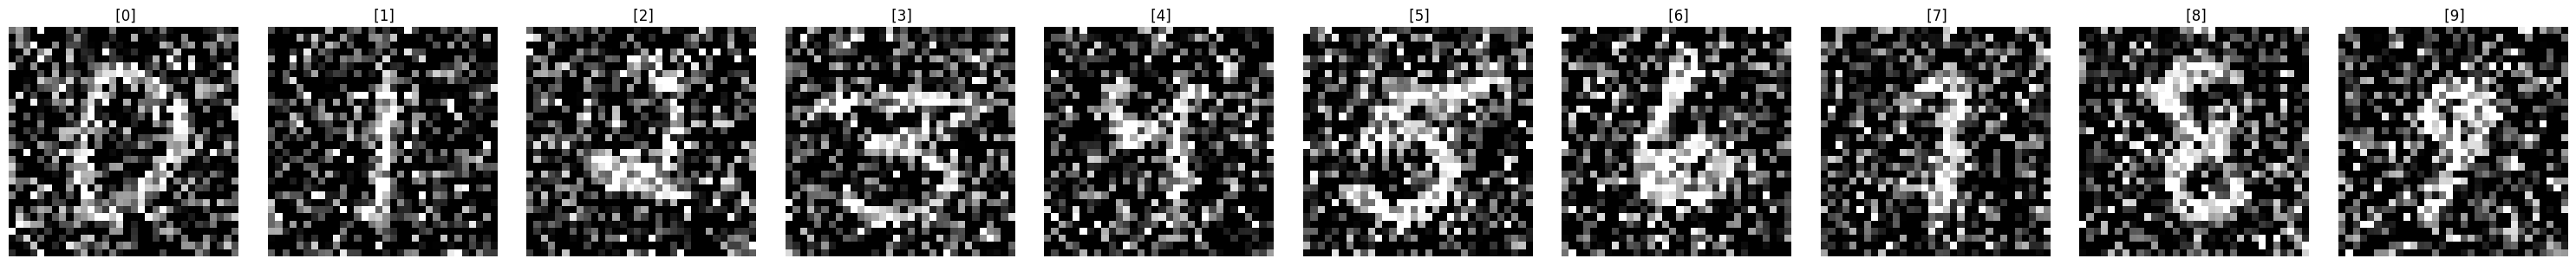

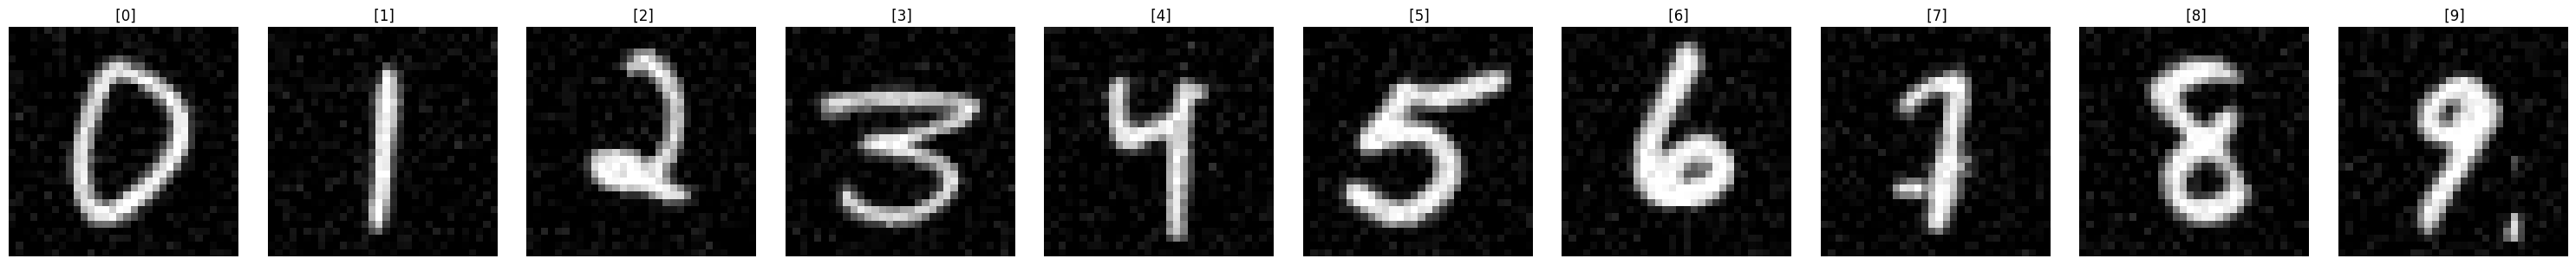

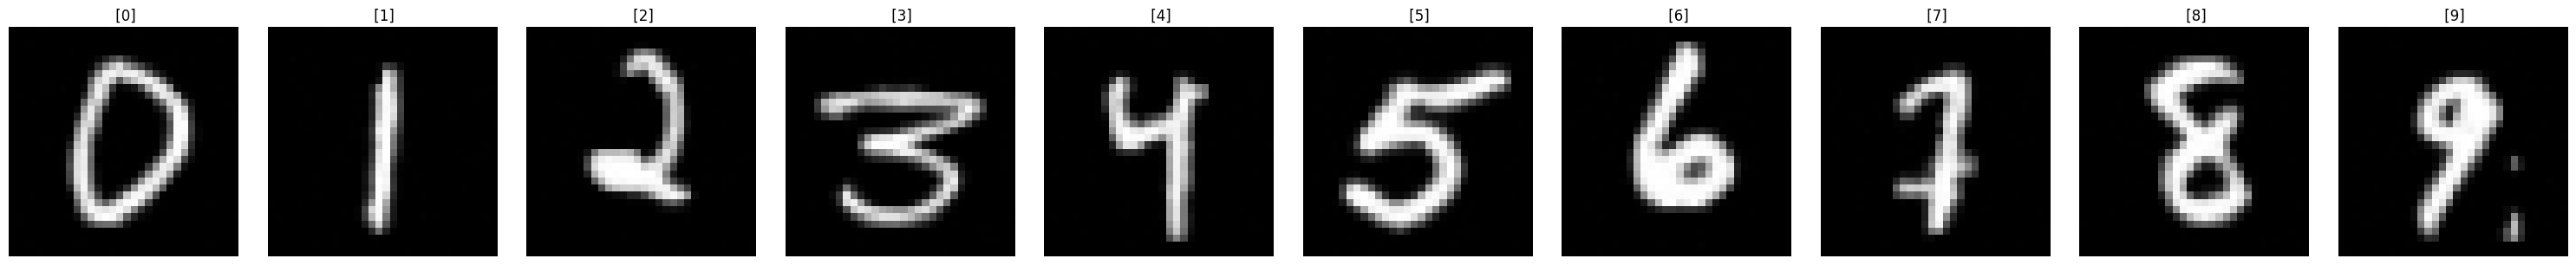

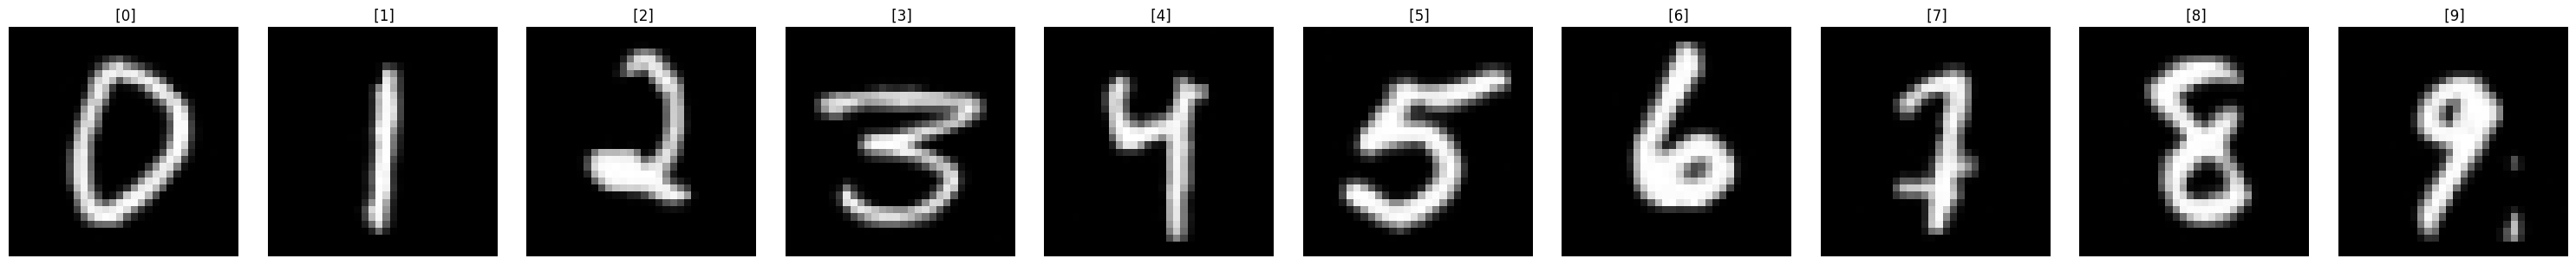

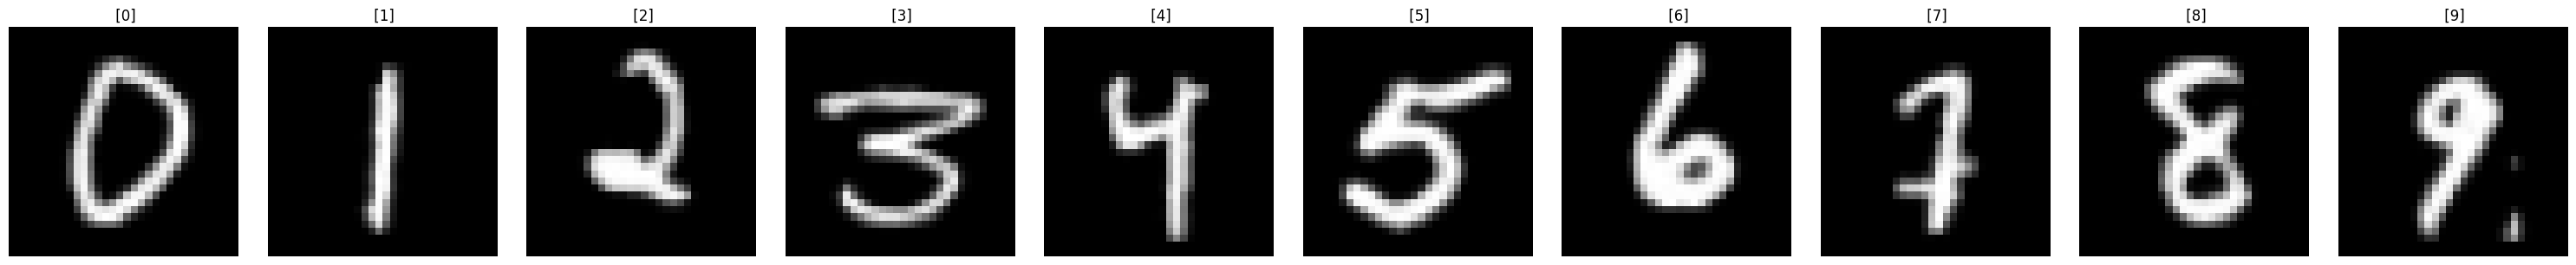

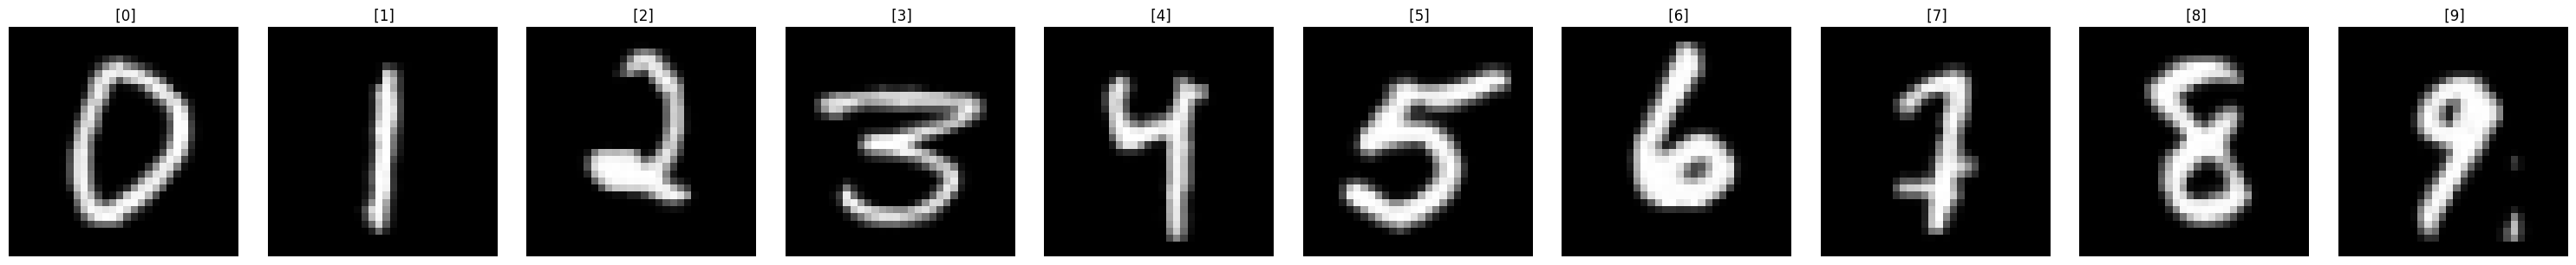

In [4]:
basic_visualize(test_clean_img, savepath="clean.png")
basic_visualize(test_noised_img, savepath="noised.png")

restore_img_1step = meanflow.simulate(model, test_noised_img.clone(), test_label.clone(), sample_steps=1)
basic_visualize(restore_img_1step.clone(), savepath="one_step.png")

restore_img_2step = meanflow.simulate(model, test_noised_img.clone(), test_label.clone(), sample_steps=2)
basic_visualize(restore_img_2step.clone(), savepath="two_step.png")

restore_img_3step = meanflow.simulate(model, test_noised_img.clone(), test_label.clone(), sample_steps=3)
basic_visualize(restore_img_3step.clone(), savepath="three_step.png")

restore_img_4step = meanflow.simulate(model, test_noised_img.clone(), test_label.clone(), sample_steps=4)
basic_visualize(restore_img_4step.clone(), savepath="four_step.png")

restore_img_5step = meanflow.simulate(model, test_noised_img.clone(), test_label.clone(), sample_steps=5)
basic_visualize(restore_img_5step.clone(), savepath="five_step.png")

In [5]:
psnr_noise = compute_psnr(test_clean_img, test_noised_img)
psnr_1step = compute_psnr(test_clean_img, restore_img_1step)
psnr_2step = compute_psnr(test_clean_img, restore_img_2step)
psnr_3step = compute_psnr(test_clean_img, restore_img_3step)
psnr_4step = compute_psnr(test_clean_img, restore_img_4step)
psnr_5step = compute_psnr(test_clean_img, restore_img_5step)

print("The mean PSNR for noised-img is: ", torch.mean(psnr_noise))
print("The mean PSNR for 1-step is: ", torch.mean(psnr_1step))
print("The mean PSNR for 2-step is: ", torch.mean(psnr_2step))
print("The mean PSNR for 3-step is: ", torch.mean(psnr_3step))
print("The mean PSNR for 4-step is: ", torch.mean(psnr_4step))
print("The mean PSNR for 5-step is: ", torch.mean(psnr_5step))

The mean PSNR for noised-img is:  tensor(6.1077, device='cuda:0')
The mean PSNR for 1-step is:  tensor(22.2994, device='cuda:0')
The mean PSNR for 2-step is:  tensor(23.5666, device='cuda:0')
The mean PSNR for 3-step is:  tensor(23.5608, device='cuda:0')
The mean PSNR for 4-step is:  tensor(23.5406, device='cuda:0')
The mean PSNR for 5-step is:  tensor(23.5278, device='cuda:0')
